In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [15]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict(), dict()]
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = glob.glob(model_dir + "/**/radar_index.pickle", recursive = True)[0]
        with open(file, 'rb') as f:
            radar_idx[m] = pickle.load(f)
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_fluxes_*.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_mtr_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att, radar_idx

In [16]:
def compare_fluxes(radar_index, fluxes_model, fluxes_radar, trial=0, context=0, src=5, dst=6):

    f_model = torch.cat([f for f in fluxes_model[trial].values()], dim=-1)
    f_model[~radar_index] = np.nan
    f_model[:, ~radar_index] = np.nan

    f_model = (f_model - f_model.permute(1, 0, 2))

    f_radar = torch.cat([f[..., context:] for f in fluxes_radar[trial].values()], dim=-1)

    
    f_model = f_model[..., 1:]
    f_radar = f_radar[..., :-1]
    
    idx = np.where(f_model.detach().numpy()!=0)
    diff = (f_model - f_radar).detach().numpy()
    print((diff[idx]**2).mean())
    
    fig, ax = plt.subplots(figsize=(18,5))
    ax.plot(f_radar[src,dst,:].detach().numpy(), label='radar', alpha=0.5)
    ax.plot(f_model[src,dst,:].detach().numpy(), label='model', alpha=0.5)
    ax.legend()
        

    fig, ax = plt.subplots(figsize=(8,8))
    fr = f_radar.detach().numpy()
    fm = f_model.detach().numpy()
    mask = np.where(np.isfinite(fm))
    ax.scatter(fr.flatten(), fm.flatten(), alpha=0.2)
#     res = sp.stats.linregress(fr[mask].flatten(), fm[mask].flatten())
    
#     sb.regplot(fr.flatten(), fm.flatten(), scatter=True, ci=95, ax=ax, label=f'R-squared={res.rvalue ** 2:.4f}',
#                    scatter_kws={'alpha': 0.2, 's': 2})
#     ax.plot([-0.2, 0.2], [-0.2, 0.2], ls='--', c='red')
#     ax.legend()
    ax.set(xlabel='radar fluxes', ylabel='model fluxes');
    
    return fig

In [17]:
def compare_fluxes_radar(voronoi, G, results, fluxes_model, fluxes_radar, trial=0, encoder=1, context=0, bird_scales={}, m='BirdFluxGraphLSTM'):
    
    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f_radar = torch.cat([f[..., :-1] for f in fluxes_radar[trial].values()], dim=-1)
    f_model = torch.cat([f[..., 1:] for f in fluxes_model[trial].values()], dim=-1)
    print(f_radar.shape, f_model.shape)

    fig1, ax1 = plt.subplots(figsize=(10,10))
    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val1 = f_model[j,i,:].detach().numpy().flatten()
            val2 = f_model[i,j,:].detach().numpy().flatten()
            fm = val1 - val2
            fr = f_radar[j,i,:].detach().numpy().flatten()
            if np.nanmean(fm) > 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()

                if not boundary1 and not boundary2:
                    #G_new.add_edge(j, i, flux=val * bird_scale)
                    sc = ax1.scatter(fr, fm, alpha=0.5, label=f'{ri} - {rj}')

#     pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

#     fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
#     edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

#     node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
#     cmap = cm.get_cmap('viridis')
#     norm = plt.Normalize(0, len(G_new.edges()))
#     edge_colors = cmap(np.arange(len(G_new.edges())))

#     fig2, ax2 = plt.subplots(figsize=(12,8))
#     options = {
#         'arrowsize': 30,
#     }
#     nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=5, ax=ax, 
#             connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
#     ax.set(title='averaged inferred fluxes between radars')
    

    ax1.set(xlabel='radar fluxes', ylabel='model fluxes');
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return fig1

In [18]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM'):

    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in all_fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [19]:
def plot_net_fluxes(voronoi, G, fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM', compute_net=True):
    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val1 = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            if compute_net:
                val = val1 - val2
            else:
                val = val1
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                #if not boundary1 and not boundary2:
#                     print(val, val2)
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred net fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [20]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

In [11]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_lstm_without_dummy_radars_encoder_batch4_n_hidden64']
results0, bird_scales0, fluxes0, _, _ = load_results(models, experiments, base_dir)

2


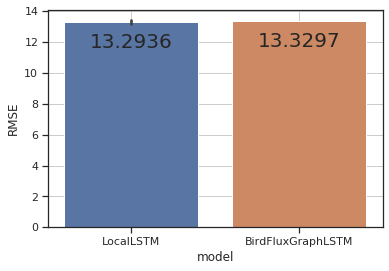

In [55]:
fig = utils.plot_average_errors(results0, boundary=boundary, night_only=True)

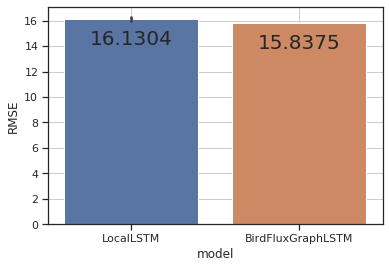

In [89]:
fig = utils.plot_average_errors(results0, boundary=[], night_only=True)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_boundary_lstm_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

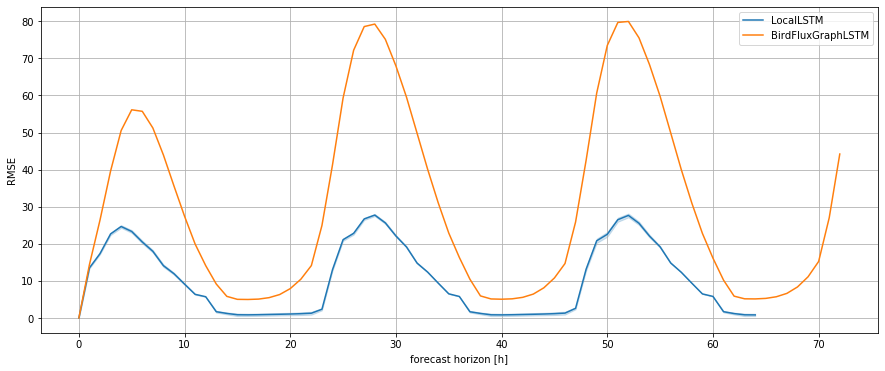

In [12]:
fig = utils.plot_errors(results0, boundary=[])

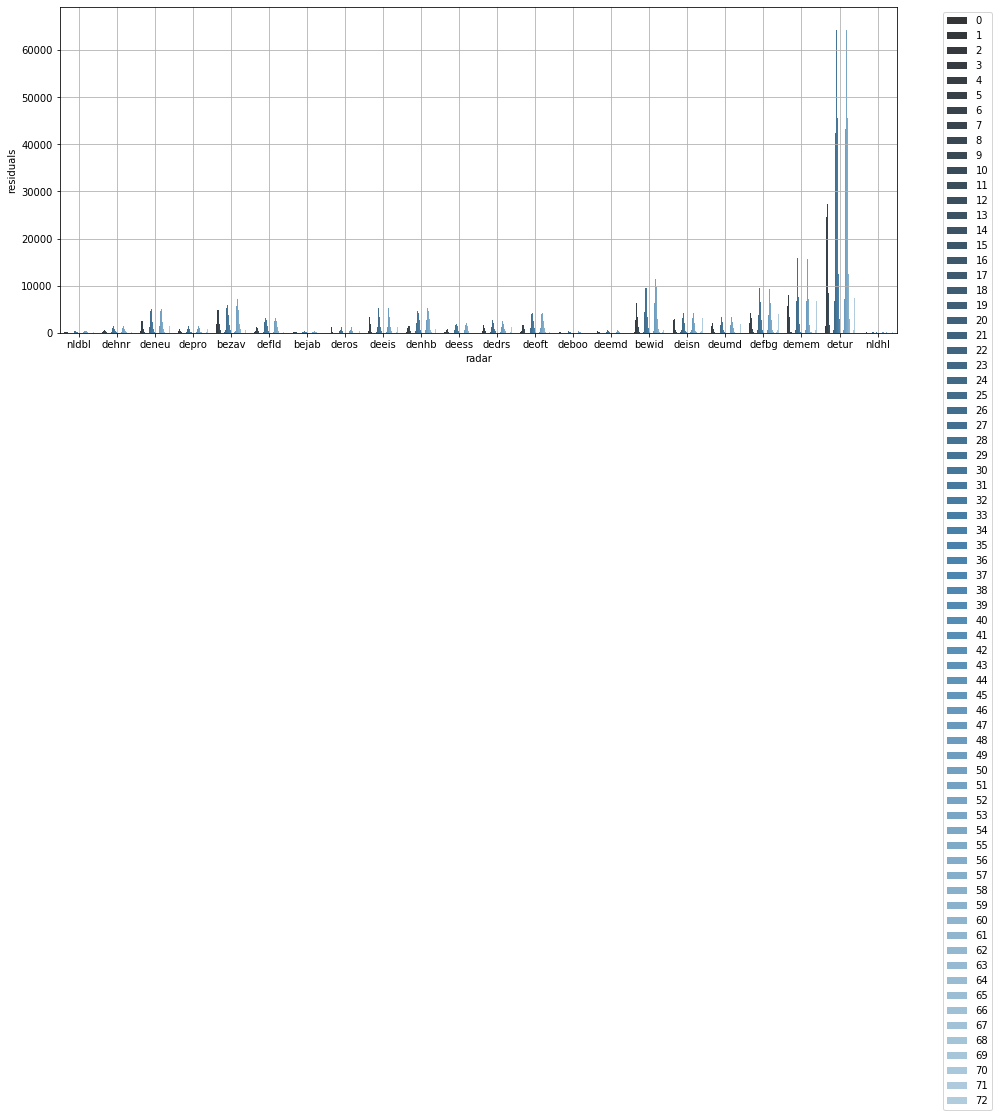

In [13]:
fig = utils.plot_errors_per_radar_and_hour(results0, 'BirdFluxGraphLSTM')

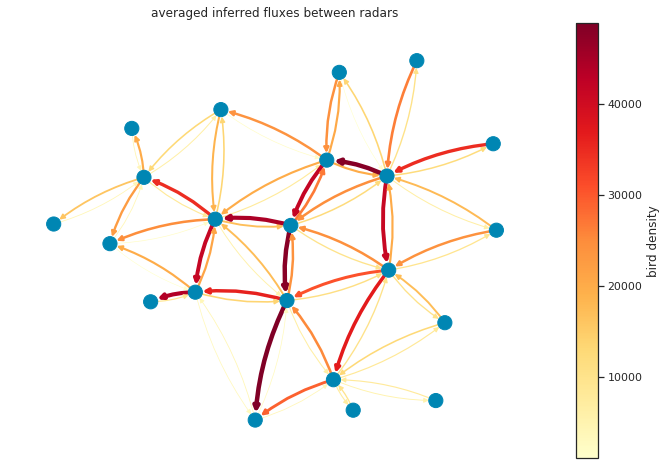

In [63]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scales=bird_scales0)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_lstm_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

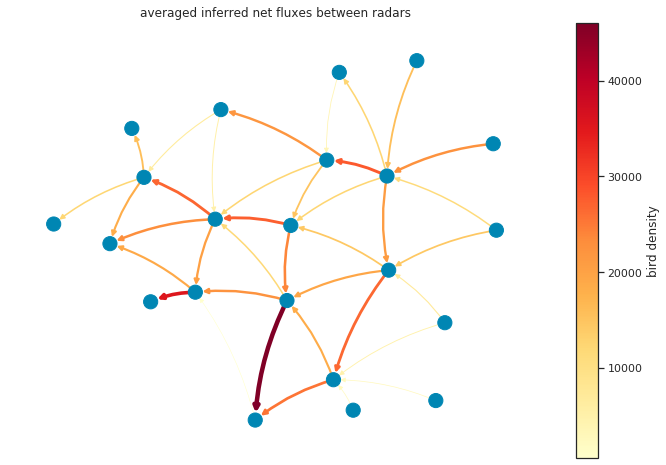

In [64]:
G_new, fig = plot_net_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scales=bird_scales0)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/net_fluxes_boundary_lstm_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

torch.Size([22, 22, 4992]) torch.Size([22, 22, 3120])


ValueError: x and y must be the same size

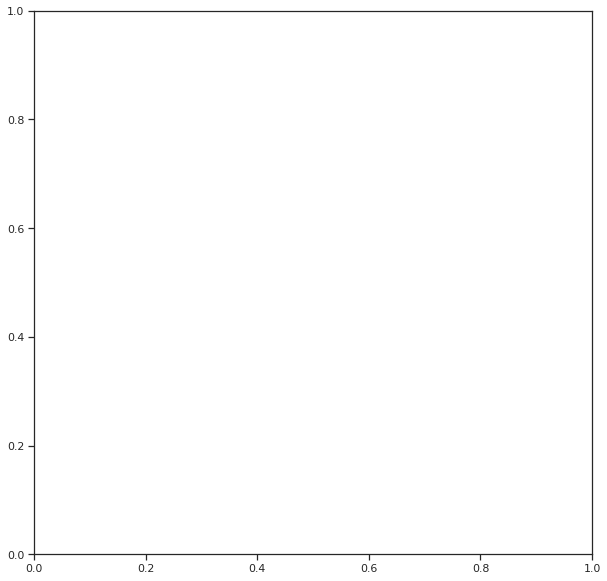

In [129]:
fig = compare_fluxes_radar(voronoi, G, results0, fluxes0[0], fluxes0[1], trial=0, encoder=1, context=0, bird_scales=bird_scales0)

nan


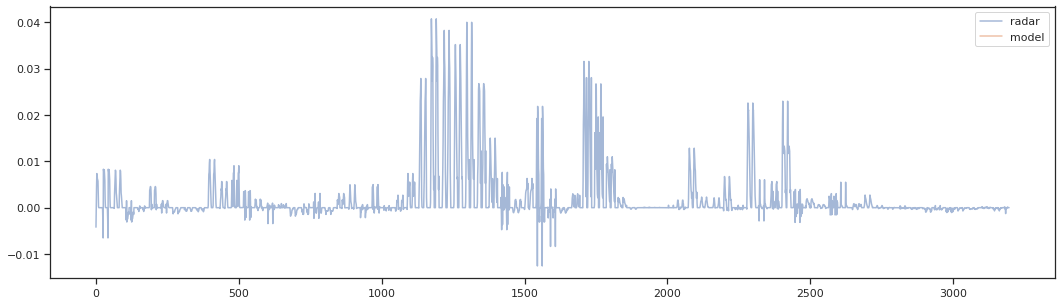

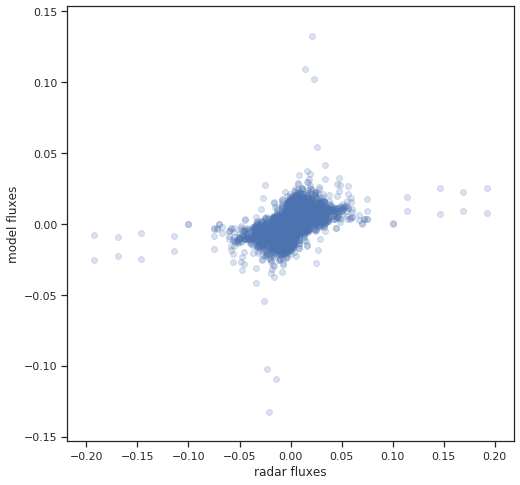

In [67]:
fig = compare_fluxes(inner_radars, fluxes0[0], fluxes0[1], trial=0, context=24, src=11, dst=2)

In [68]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/scatter_net_fluxes_boundary_lstm_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

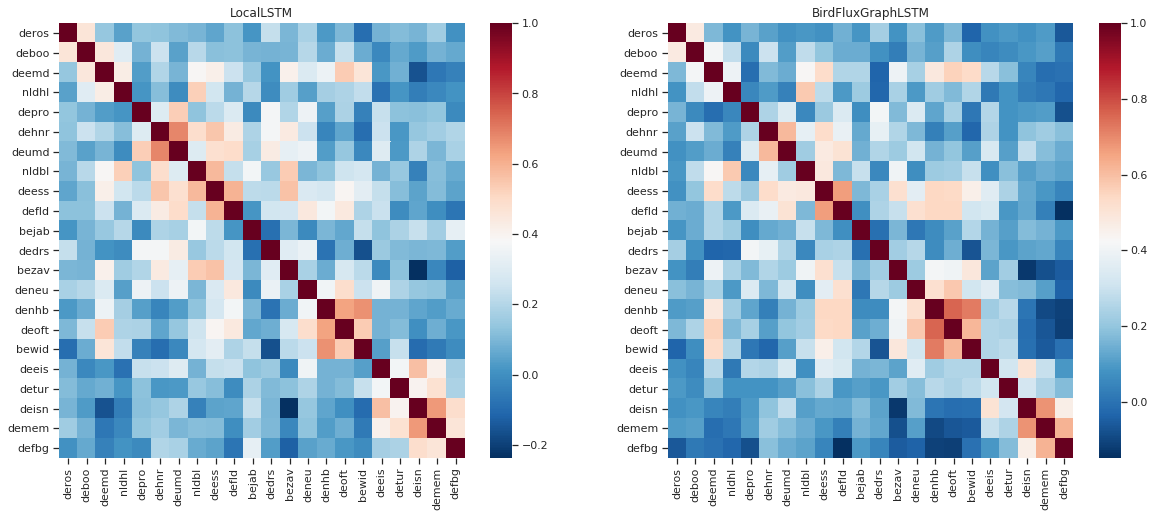

In [70]:
fig = utils.residuals_corr(results0, ['LocalLSTM', 'BirdFluxGraphLSTM'], voronoi)

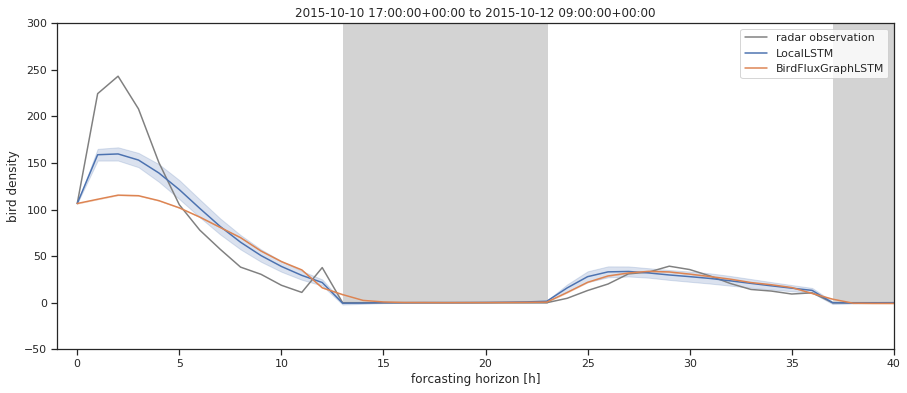

In [65]:
fig = utils.plot_example_prediction(results0, 'defld', 44, max=300, min=-50)

In [77]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_lstm_without_dummy_radars_encoder_batch4_n_hidden128_new']
results1, bird_scales1, fluxes1, _, _ = load_results(models, experiments, base_dir)

1


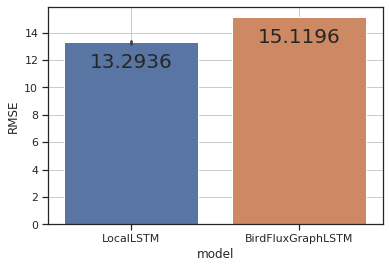

In [78]:
fig = utils.plot_average_errors(results1, boundary=boundary, night_only=True)

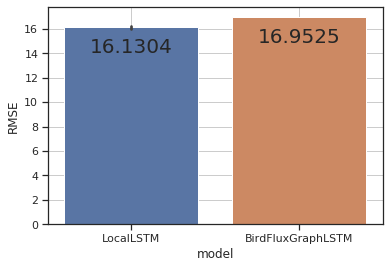

In [79]:
fig = utils.plot_average_errors(results1, boundary=[], night_only=True)

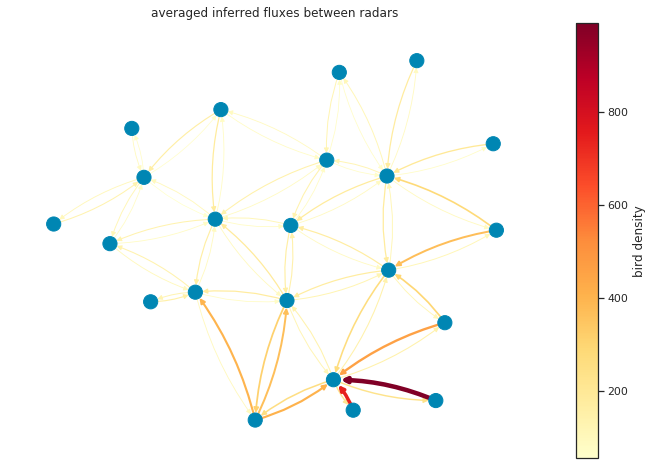

In [80]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes1[0], results1, trial=0, encoder=1, bird_scales=bird_scales1)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_lstm_weighted_fluxes_contraint01_n_hidden128.png', bbox_inches='tight', dpi=300)

nan


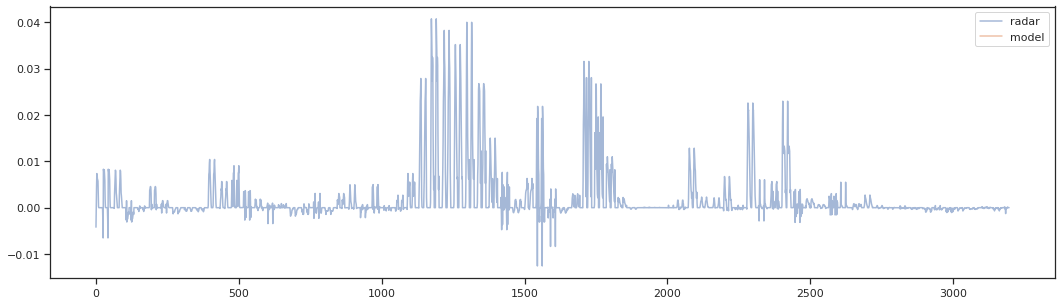

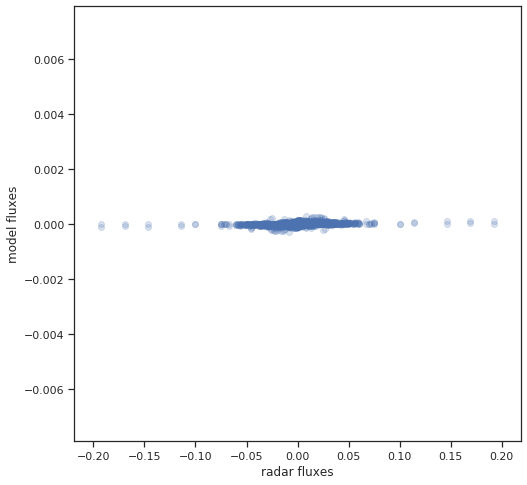

In [81]:
fig = compare_fluxes(inner_radars, fluxes1[0], fluxes1[1], trial=0, context=24, src=11, dst=2)

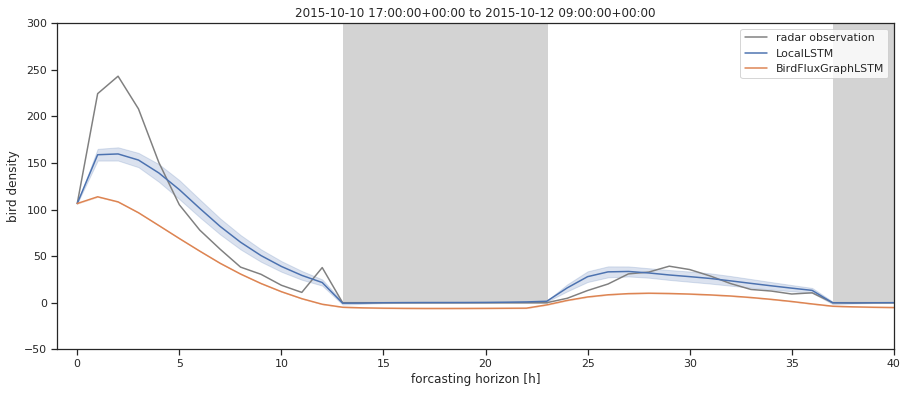

In [82]:
fig = utils.plot_example_prediction(results1, 'defld', 44, max=300, min=-50)

In [112]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_lstm_without_dummy_radars_encoder_batch1_n_hidden64_new']
results1, bird_scales1, fluxes1, _, _ = load_results(models, experiments, base_dir)

3


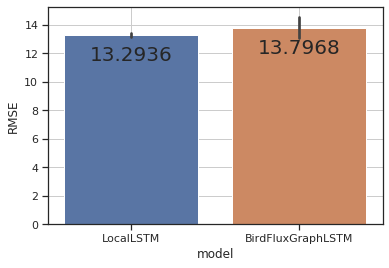

In [113]:
fig = utils.plot_average_errors(results1, boundary=boundary, night_only=True)

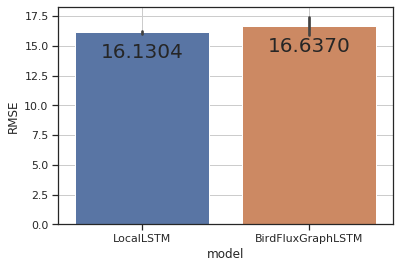

In [114]:
fig = utils.plot_average_errors(results1, boundary=[], night_only=True)

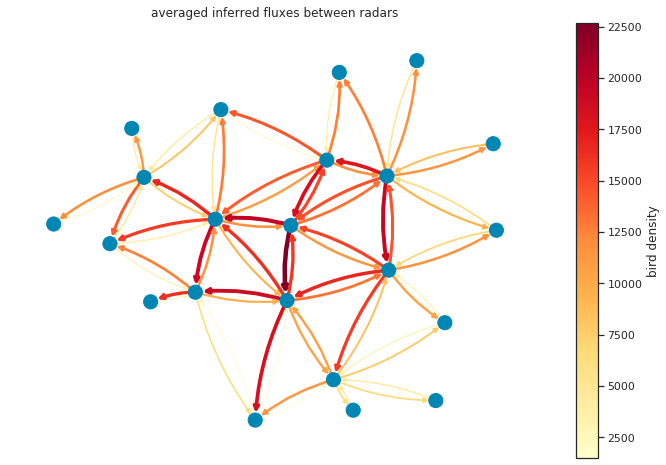

In [115]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes1[0], results1, trial=0, encoder=1, bird_scales=bird_scales1)

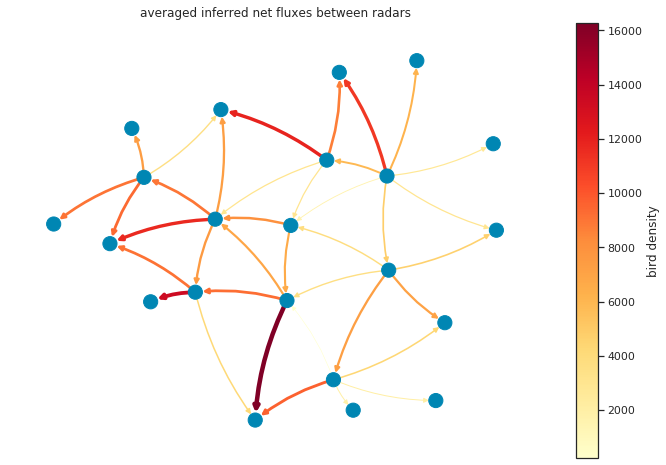

In [116]:
G_new, fig = plot_net_fluxes(voronoi, G, fluxes1[0], results1, trial=0, encoder=1, bird_scales=bird_scales1)

In [21]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_lstm_without_dummy_radars_encoder_batch1_n_hidden64_new_constraint001']
results2, bird_scales2, fluxes2, _, _ = load_results(models, experiments, base_dir)

3


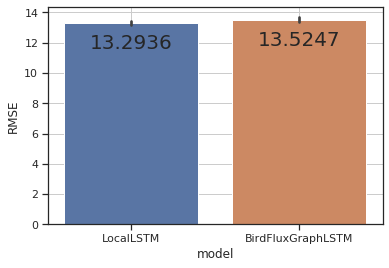

In [118]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

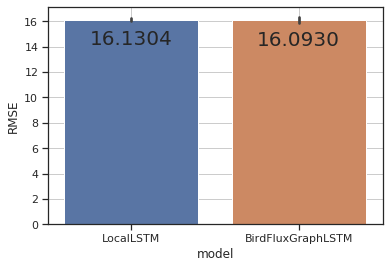

In [130]:
fig = utils.plot_average_errors(results2, boundary=[], night_only=True)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_boundary_lstm_weighted_fluxes_contraint001.png', bbox_inches='tight', dpi=300)

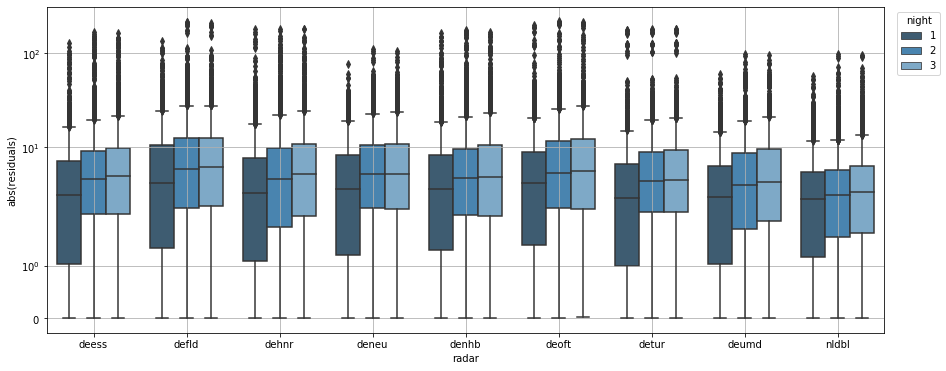

In [72]:
model = 'BirdFluxGraphLSTM'
results = results2
bird_scales={}

df = results[model]
df = df[~df.radar.isin(boundary)]
df = df[df.gt_km2 > 0]
df = df.sort_values('radar')

df['residual_km2'] = df.residual_km2.apply(np.abs)

radars = voronoi.sort_values('lat', ascending=False).radar.values
radars = [r for r in radars if r not in boundary]

df['period'] = (df.horizon // 24) + 1

# with sb.color_palette("icefire", n_colors=df.radar.unique().size):
fig, ax = plt.subplots(figsize=(15, 6))
sb.boxplot(x='radar', y='residual_km2', hue='period', data=df, palette="Blues_d")
plt.grid()
ax.set(ylabel='abs(residuals)', yscale='symlog')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='night')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/abs_residuals_per_night_boundary_lstm_weighted_fluxes_contraint001.png', bbox_inches='tight', dpi=300)

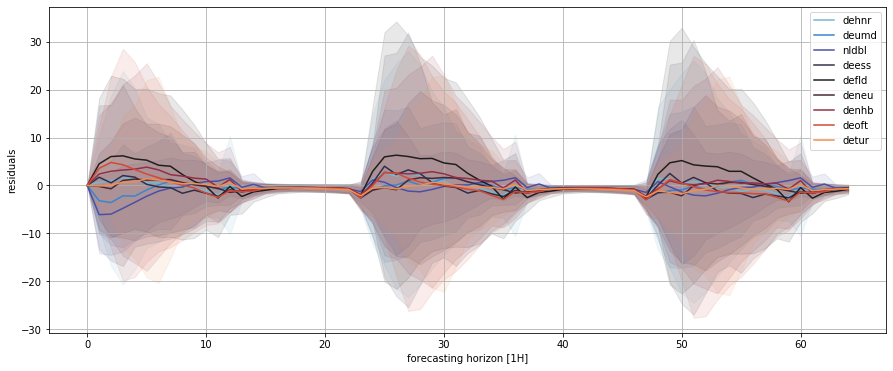

In [75]:
model = 'BirdFluxGraphLSTM'
results = results2
bird_scales={}

df = results[model]
df = df[~df.radar.isin(boundary)]
# df = df[df.gt_km2 > 25]

radars = voronoi.sort_values('lat', ascending=False).radar.values
radars = [r for r in radars if r not in boundary]

mean_res = df.groupby(['horizon', 'radar']).residual_km2.aggregate(np.nanmean).reset_index()
std_res = df.groupby(['horizon', 'radar']).residual_km2.aggregate(np.nanstd).reset_index()

with sb.color_palette("icefire", n_colors=df.radar.unique().size):
    fig, ax = plt.subplots(figsize=(15, 6))

#     for r, data in mean_res.groupby(['radar']):
    for r in radars:
        data = mean_res.query(f'radar == "{r}"')
        l = ax.plot(data.horizon.values, data.residual_km2.values, label=r)
        std_df = std_res.query(f'radar == "{r}"')
        ax.fill_between(std_df.horizon.values, data.residual_km2.to_numpy() - std_df.residual_km2.to_numpy(),
                       data.residual_km2.to_numpy() + std_df.residual_km2.to_numpy(), color=l[0].get_color(), alpha=0.1)
    #sb.lineplot(x='horizon', y='error', data=mean_res[['horizon', 'error']], ax=ax)
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.legend(loc='upper right')
    plt.grid()
    ax.set(ylabel='residuals', xlabel='forecasting horizon [1H]')
    fig.savefig('/home/fiona/birdMigration/data/plots/presentations/residuals_boundary_lstm_weighted_fluxes_contraint001.png', bbox_inches='tight', dpi=300)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


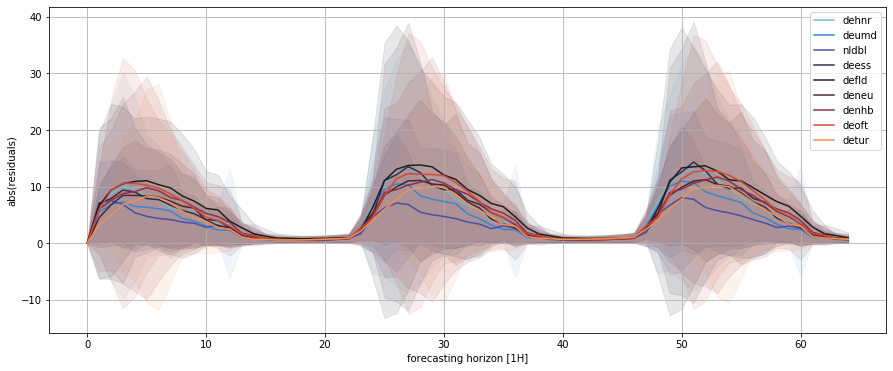

In [40]:
model = 'BirdFluxGraphLSTM'
results = results2
bird_scales={}

df = results[model]
df = df[~df.radar.isin(boundary)]

radars = voronoi.sort_values('lat', ascending=False).radar.values
radars = [r for r in radars if r not in boundary]

df['err'] = df.residual_km2.apply(np.abs)
mean_res = df.groupby(['horizon', 'radar']).err.aggregate(np.nanmean).reset_index()
std_res = df.groupby(['horizon', 'radar']).err.aggregate(np.nanstd).reset_index()

with sb.color_palette("icefire", n_colors=df.radar.unique().size):
    fig, ax = plt.subplots(figsize=(15, 6))

#     for r, data in mean_res.groupby(['radar']):
    for r in radars:
        data = mean_res.query(f'radar == "{r}"')
        l = ax.plot(data.horizon.values, data.err.values, label=r)
        std_df = std_res.query(f'radar == "{r}"')
        ax.fill_between(std_df.horizon.values, data.err.to_numpy() - std_df.err.to_numpy(),
                       data.err.to_numpy() + std_df.err.to_numpy(), color=l[0].get_color(), alpha=0.1)
    #sb.lineplot(x='horizon', y='error', data=mean_res[['horizon', 'error']], ax=ax)
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.legend(loc='upper right')
    plt.grid()
    ax.set(ylabel='abs(residuals)', xlabel='forecasting horizon [1H]')
    fig.savefig('/home/fiona/birdMigration/data/plots/presentations/abs_residuals_boundary_lstm_weighted_fluxes_contraint001.png', bbox_inches='tight', dpi=300)

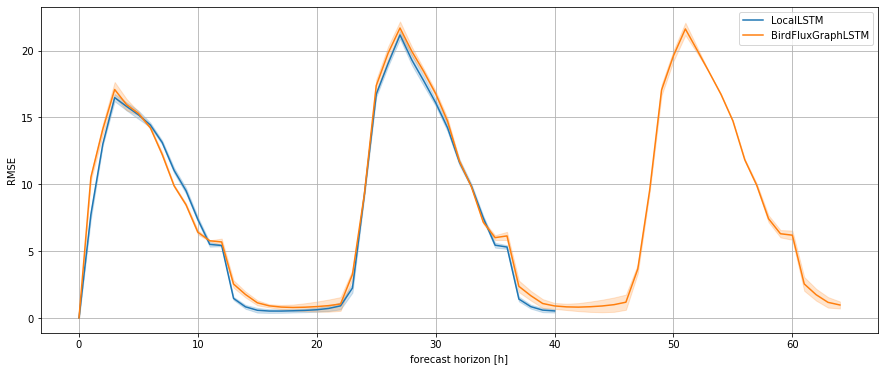

In [25]:
fig = utils.plot_errors(results2, boundary=boundary)

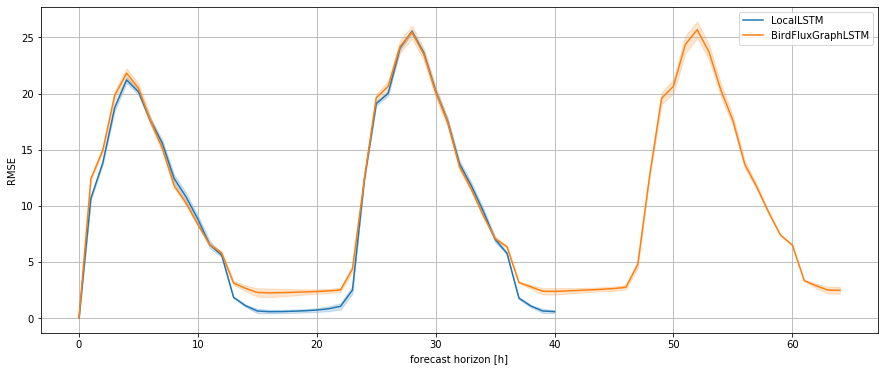

In [20]:
fig = utils.plot_errors(results2, boundary=[])

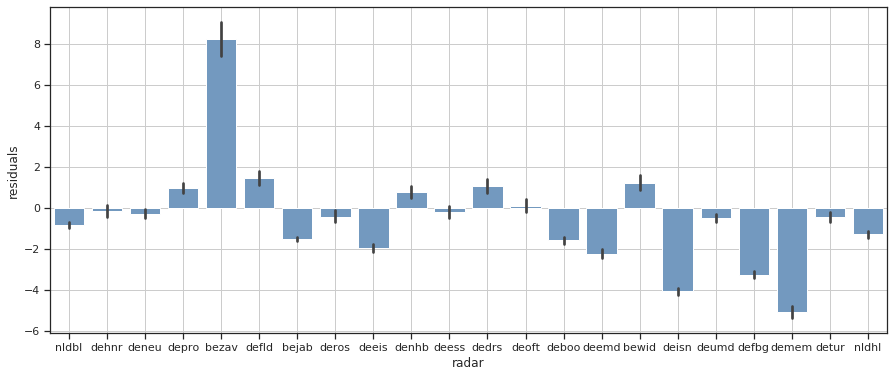

In [137]:
fig = utils.plot_errors_per_radar(results2, 'BirdFluxGraphLSTM')

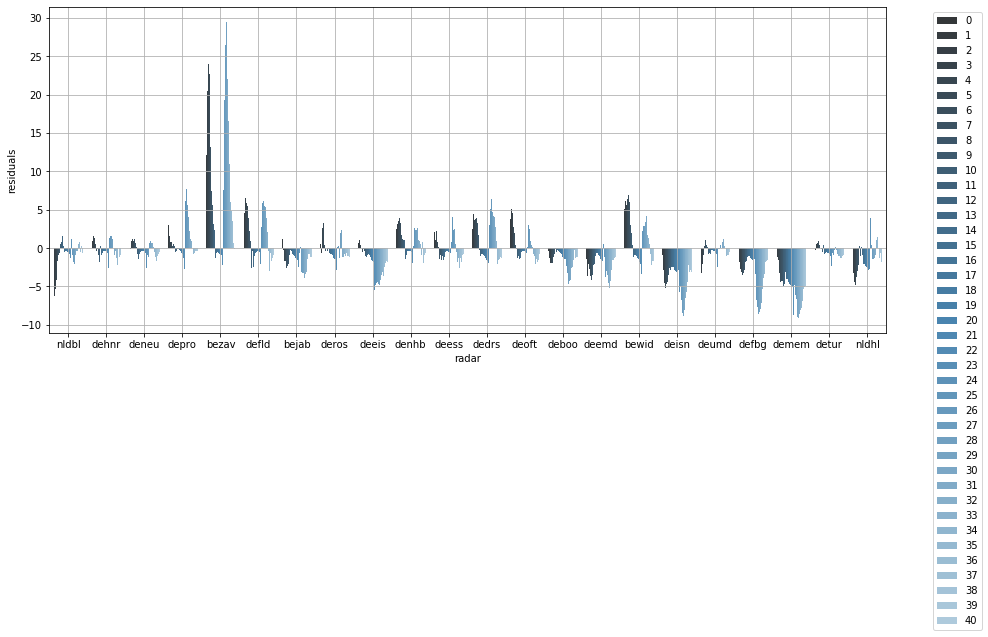

In [9]:
fig = utils.plot_errors_per_radar_and_hour(results2, 'BirdFluxGraphLSTM')

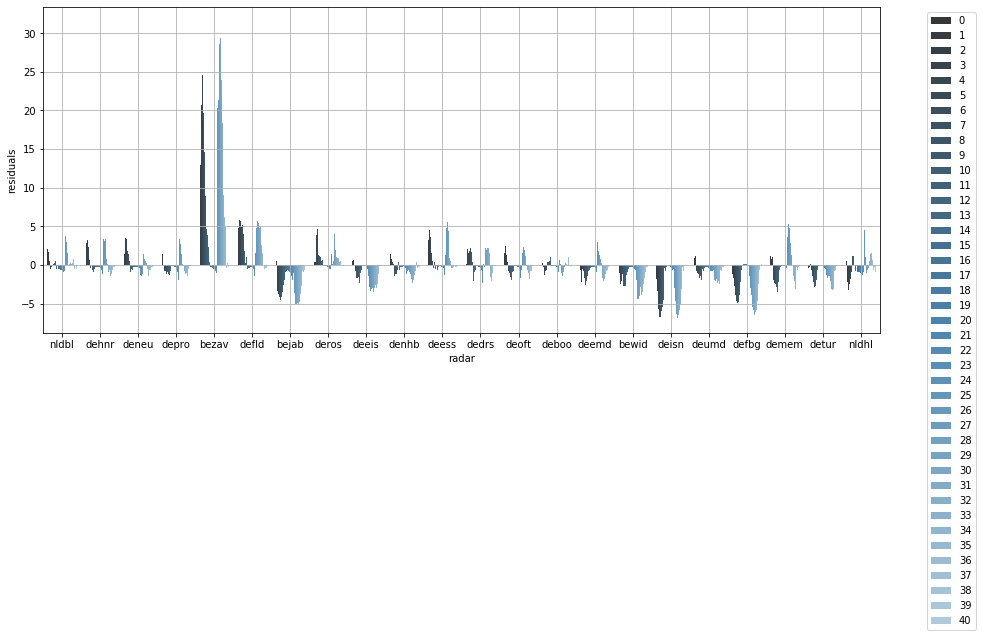

In [10]:
fig = utils.plot_errors_per_radar_and_hour(results2, 'LocalLSTM')

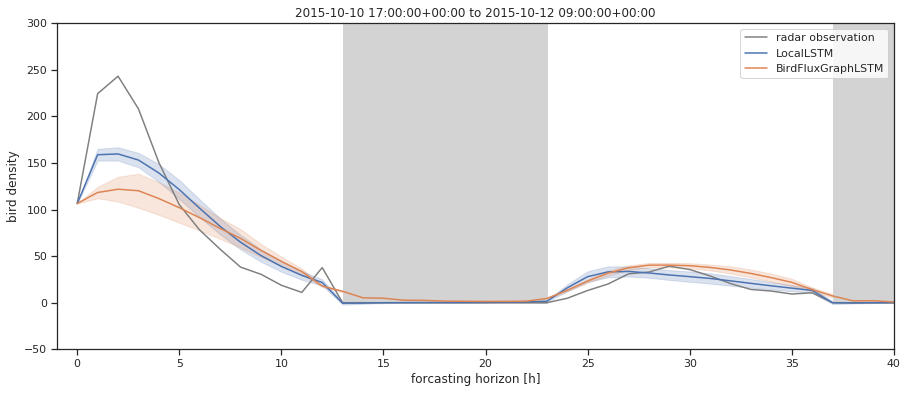

In [133]:
fig = utils.plot_example_prediction(results2, 'defld', 44, max=300, min=-50)

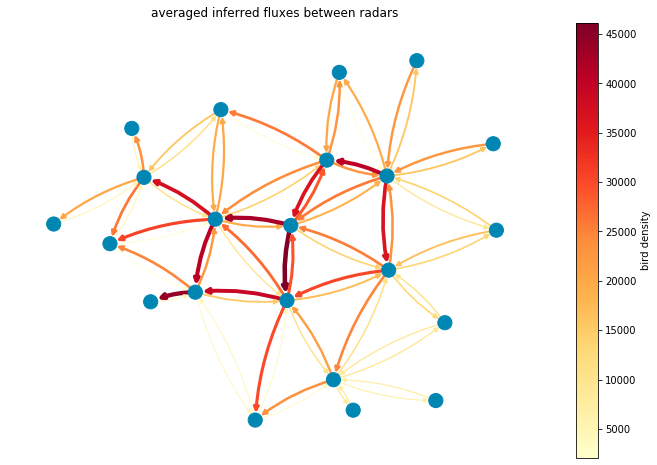

In [38]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)
G_new, fig = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_lstm_weighted_fluxes_contraint001.png', bbox_inches='tight', dpi=300)

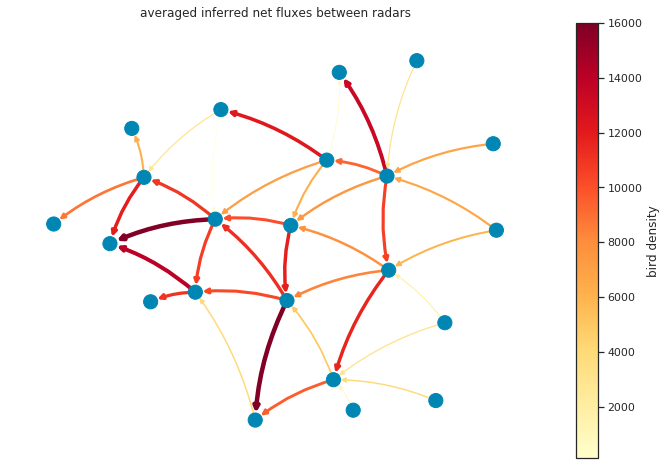

In [131]:
G_new, fig = plot_net_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/net_fluxes_boundary_lstm_weighted_fluxes_contraint001.png', bbox_inches='tight', dpi=300)

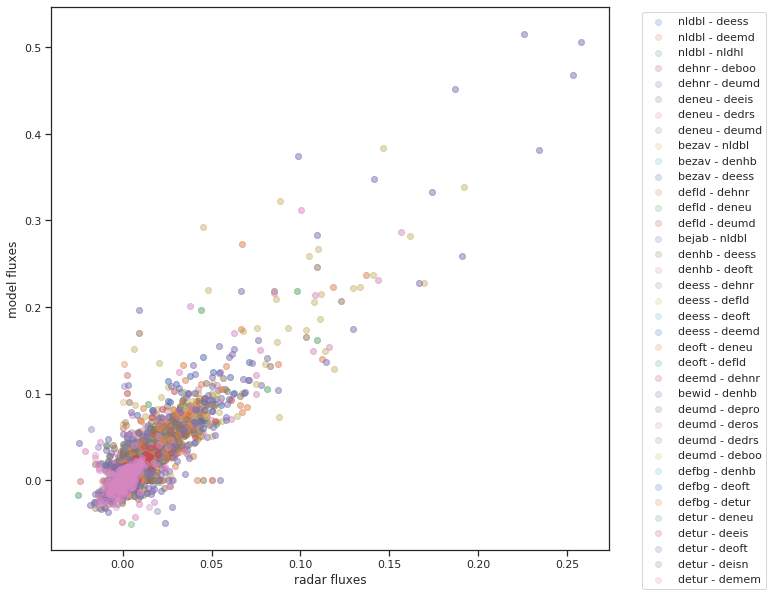

In [123]:
fig = compare_fluxes_radar(voronoi, G, results2, fluxes2[0], fluxes2[1], trial=0, encoder=1, context=0, bird_scales=bird_scales2)

nan


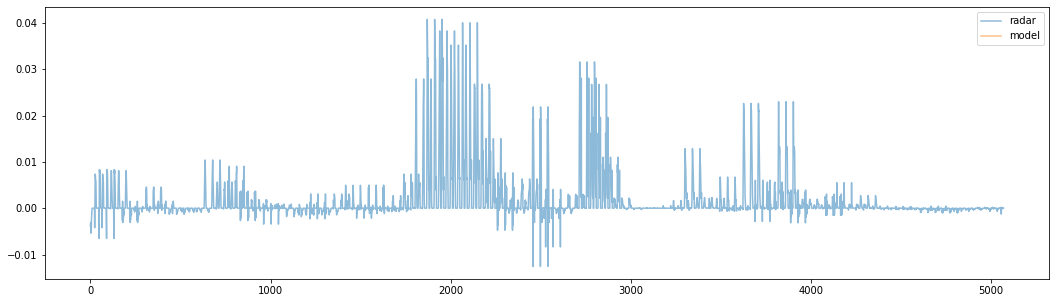

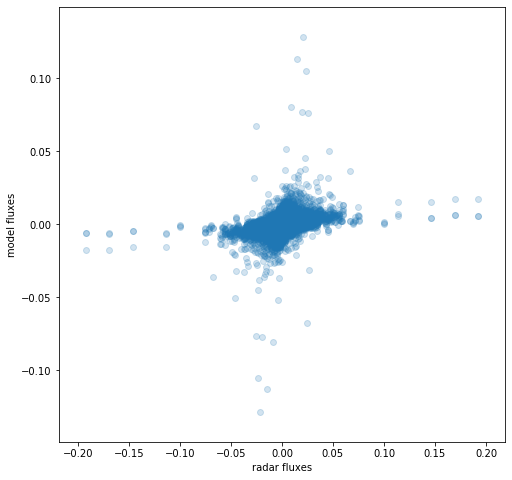

In [39]:
fig = compare_fluxes(inner_radars, fluxes2[0], fluxes2[1], trial=0, context=24, src=11, dst=2)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/scatter_net_fluxes_boundary_lstm_weighted_fluxes_contraint001.png', bbox_inches='tight', dpi=300)